# Algorithm Clustering Ant

In [1]:
%matplotlib inline

In [60]:
from random import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random as rd
import math as mt
from copy import copy, deepcopy
from functools import reduce

In [3]:
# Estado que cada célula pode assumir
NO_ANT = 0
ANT_UNLOADED = 1
ANT_L1 = 2
ANT_L2 = 3

NO_LOAD = 0
L1 = 196
L2 = 46

EMPTY_CELL           = (NO_ANT, NO_LOAD)
NO_ANT_W_L1          = (NO_ANT, L1)
NO_ANT_W_L2          = (NO_ANT, L2)
ANT_UNLOADED_NO_LOAD = (ANT_UNLOADED, NO_LOAD)

In [4]:
def neighborhood(grid, pair):
    x = pair[0]
    min_x = (x - 1) if ((x - 1) >= 0) else x
    max_x = (x + 1) if ((x + 1) < len(grid)) else x
    
    y = pair[1]
    min_y = (y - 1) if ((y - 1) >= 0) else y
    max_y = (y + 1) if ((y + 1) < len(grid)) else y
    
    return list({
        (min_x, min_y), (min_x, y), (min_x, max_y), 
        (max_x, min_y), (max_x, y),(max_x, max_y),
        (x, min_y), (x, y), (x, max_y)
    })

In [5]:
# Cálculo da fração de itens percebidos na vizinhaça da formiga
# Pode ser percebido como visibilidade de cada formiga
def f(grid, ant, load_type):
    neighbors = neighborhood(grid, ant)
    quantity = 0
    
    for n in neighbors:
        value = grid[n[0]][n[1]]
        if value[1] == load_type:
            quantity += 1
        
    return quantity/len(neighbors)

In [6]:
# Cálculo da probabilidade de uma formiga pegar um item uma vez descarregada e numa célula com item
# p_pick = (k1/(k1+f))²
def p_pick(grid, k1, ant, load_type):
    return mt.pow((k1 / (k1 + f(grid, ant, load_type))), 2)

In [7]:
# Cálculo da probabilidade de uma formiga deixar um item uma vez carregada e numa célula sem item
# p_drop = (f/(k2+f))²
def p_drop(grid, k2, ant, load_type):
    return mt.pow((f(grid, ant, load_type) / (k2 + f(grid, ant, load_type))), 2)

In [8]:
def move_ant(grid, ants, ant):
    possible_positions = neighborhood(grid, ant)
    condition = True
    
    while condition:
        # Pega uma posição aleatória
        new_pos = possible_positions[randint(0, len(possible_positions) - 1)]
        # Valor desta posição aleatória
        new_value = grid[new_pos[0]][new_pos[1]]
        
        if new_value[0] == NO_ANT: # Verifica se a nova posição não há formiga
            old_pos = ant
            old_value = grid[old_pos[0]][old_pos[1]]
            
            grid[old_pos[0]][old_pos[1]] = (NO_ANT, old_value[1])            
            grid[new_pos[0]][new_pos[1]] = (old_value[0], new_value[1])
            
            i = ants.index(ant)
            ants.remove(ant)
            ants.insert(i, new_pos)
            condition = False
        else:
            possible_positions.remove(new_pos)
            if (len(possible_positions) == 0):
                condition = False
    
    return grid, ants

In [50]:
def ACA(max_it, size_grid, n_ants, n_load, n_load2, k1, k2):
    grid = [[EMPTY_CELL] * size_grid for i in range(size_grid)]
    ants = [] # Posição das formigas
    loads = [] # Posição das cargas
    
    # ANT_UNLOADED_NO_LOAD = {ANT_UNLOADED, NO_LOAD}
    # Posicionamento inicial das formigas no grid
    ant = 0
    while ant < n_ants:
        x, y = (randint(0, size_grid - 1), randint(0, size_grid - 1))
        if grid[x][y] == EMPTY_CELL:
            grid[x][y] = ANT_UNLOADED_NO_LOAD
            ants.append((x,y))
            ant = ant + 1
    
    # NO_ANT_W_L1 = {NO_ANT, L1}
    # Posicionamento inicial das cargas no grid
    load = 0
    while load < n_load:
        x,y = (randint(0, size_grid - 1), randint(0, size_grid - 1))
        if grid[x][y] == EMPTY_CELL:
            grid[x][y] = NO_ANT_W_L1
            loads.append((x, y))
            load = load + 1
    
    # NO_ANT_W_L2 = {NO_ANT, L2}
    # Posicionamento inicial das cargas no grid
    load2 = 0
    while load2 < n_load2:
        x,y = (randint(0, size_grid - 1), randint(0, size_grid - 1))
        if grid[x][y] == EMPTY_CELL:
            grid[x][y] = NO_ANT_W_L2
            loads.append((x, y))
            load2 = load2 + 1
    
    init_grid = deepcopy(grid)
    
    for t in range(max_it): # Repetir para max_it iterações
        for a in ants: # Repetir para cada formiga
            content_pos = grid[a[0]][a[1]]
            
            if content_pos[0] == ANT_UNLOADED and content_pos[1] != NO_LOAD: # Se a formiga está descarregada e há um item
                if rd.random() <= p_pick(grid, k1, a, content_pos[1]):
                    if content_pos[1] == L1:
                        grid[a[0]][a[1]] = (ANT_L1, NO_LOAD)
                    elif content_pos[1] == L2:
                        grid[a[0]][a[1]] = (ANT_L2, NO_LOAD)
            
            if content_pos[0] != ANT_UNLOADED and content_pos[1] == NO_LOAD: # Se a formiga está carregada e não há um item
                load_type = 0
                if content_pos[0] == ANT_L1:
                    load_type = L1
                elif content_pos[0] == ANT_L2:
                    load_type = L2
                if rd.random() <= p_drop(grid, k2, a, load_type):
                    grid[a[0]][a[1]] = (ANT_UNLOADED, load_type)
            
            grid, ants = move_ant(grid, ants, a) # Movimentar aleatoriamente a formiga
    
    num_ants_loaded = 0
    for ant in ants:
        ant_value = grid[ant[0]][ant[1]]
        if ant_value[0] != ANT_UNLOADED:
            num_ants_loaded = num_ants_loaded + 1 
    
    return init_grid, grid, num_ants_loaded*100.0/len(ants)

In [10]:
def matrix_plot(g):
    m = [[0] * len(g) for i in range(len(g))]    
    for i in range(len(g)):
        for j in range(len(g)):
            value = g[i][j]
            if value == EMPTY_CELL:
                m[i][j] = 0
            elif value[0] == NO_ANT or value[0] == ANT_UNLOADED:
                m[i][j] = value[1]
            else:
                m[i][j] = 80
            
    return m

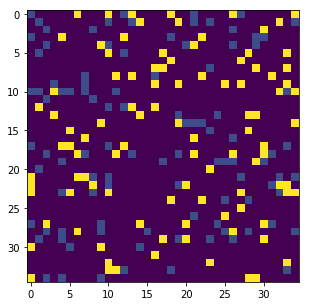

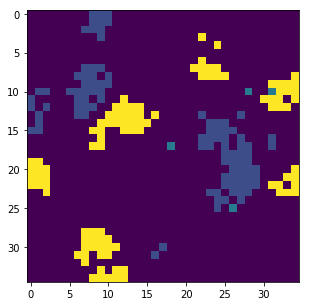

40.0


In [52]:
# Inicialização do algoritmo
i,e,p = ACA(max_it=100000, size_grid=35, n_ants=10, n_load=100, n_load2=100, k1=0.05, k2=0.95)

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(matrix_plot(i))
plt.show()
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(matrix_plot(e))
plt.show()
print(p)

In [ ]:
def plotMatrices(times, max_it, size_grid, n_ants, n_load, n_load2, k1, k2):
    rows = times
    columns = 2
    images = []
    p_title = []
    ps = []
    
    for i in range(rows):
        start,end,p = ACA(max_it, size_grid, n_ants, n_load, n_load2, k1, k2)
        images.append(matrix_plot(start))
        images.append(matrix_plot(end))
        p_title.append('')
        p_title.append(p)
        ps.append(p)
    
    for j in range(rows * columns):
        image = images[j]
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.subplot(rows, columns, j + 1)
        plt.title('{}'.format(p_title[j]))
        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    avg = reduce((lambda x, y: x + y), ps)/(len(ps) * 1.0)
    print('Average: {}'.format(avg))

/usr/local/lib/python3.5/dist-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


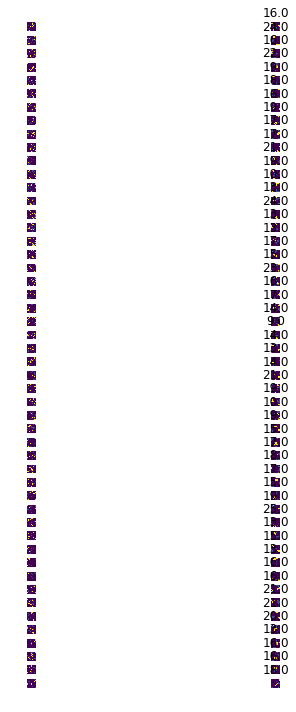

Average: 16.84


In [77]:
plotMatrices(times=50, max_it=100000, size_grid=35, n_ants=100, n_load=100, n_load2=100, k1=0.05, k2=0.95)

In [ ]:
22.0
15.8